In [1]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import pandas as pd
from openpyxl import load_workbook
import re
import io
import os
import pdb

import sys
sys.path.append(os.path.abspath('../kev/'))

import eq_data
import eq_preproc
import eq_evaluator
import eq_postproc
import eq_writer


# basic input ------------------------------------------------
 
def cl_scripts_load(_sep, _subdir, _file):
    
    # if specific file selected it should be XLSX one
    if _file != "":
        
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        _file = _subdir + _file
        
        # open excel file
        with open(_file, "rb") as f:
            inmemory_file = io.BytesIO(f.read())
        wb = load_workbook(inmemory_file, read_only = True)
                
        r = re.compile(r'heats')
        heats_data = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], index_col = 0)
        
        r = re.compile(r'targets')
        targets = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], header = None)
        
        r = re.compile(r'enthalpies')
        delta_H = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0])
        
        r = re.compile(r'setup')
        setup = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], header = None, index_col = 0)
        
    # use a bunch of plain text files instead
    else:
          
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        file_names = list(os.listdir(path = _subdir))

        r = re.compile(r'heats')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        heats_data = pd.read_csv(file, sep = _sep, decimal = ".", index_col = 0)
        
        r = re.compile(r'targets')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        targets = pd.read_csv(file, sep = _sep, header = None)
        
        r = re.compile(r'enthalpies')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        delta_H = pd.read_csv(file, sep = _sep, decimal = ".")
        
        r = re.compile(r'setup')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        setup = pd.read_csv(file, sep = _sep, header = None, index_col = 0, decimal = ".")
        
    return heats_data, targets, delta_H, setup

In [2]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np
import re

# basic preprocessing ----------------------------------------
    
def cl_preproc(con_data, prod_names, idx, type_con, heats_data, targets, delta_H, setup):
    
    # checking if there are several series
    
    if 'series' not in con_data.columns:        
        con_data['series'] = ''
    
    if 'series' not in heats_data.index:
        heats_data.loc['series'] = '' # probably not needed
    
    if 'volumes' not in heats_data.index:
        heats_data.loc['volumes'] = 1        

    # series variables
    
    ser_info = con_data['series'].to_numpy()
    ser_unique = np.unique(ser_info)
    ser_num = np.shape(np.unique(ser_info))[0]
    
    ser_counts = con_data.groupby(['series']).size().tolist();
    
    # reading volumes from experimental data
    volumes = heats_data.loc['volumes'].to_numpy()
    
    # reading exp heats from experimental data
    heats = heats_data.loc['observation'].to_numpy() - heats_data.loc['dilution'].to_numpy()
        
    # transforming deviation to the matrix form
    devs = heats_data.loc['deviation'].to_numpy()
    devs = np.diag((1 / (np.array(devs) * np.array(devs))) * (np.sum(np.array(devs) * np.array(devs)) / len(devs)))
    
    # creating vector of known enthalpies
    dH_par = np.hstack((np.zeros(len(prod_names_con)), np.transpose(delta_H.drop('Reaction', axis = 1).to_numpy())[0]))
    
    # number of constant to find
    tar_names = set(targets.to_numpy()[0][1:])
    tar_num = [index for index, item in enumerate(prod_names) if item in tar_names]
    
    # number of enthalpy to find
    dH_names = np.hstack((prod_names_con, np.transpose(delta_H.drop('Value', axis = 1).to_numpy())[0]))
    un_el = set(prod_names) - set(dH_names)
    dH_ind_wtf = list([index for index, item in enumerate(prod_names) if item in un_el])
    un_el = set(prod_names) - (set(prod_names) - set(dH_names))
    dH_ind = list([index for index, item in enumerate(prod_names) if item in un_el])
    
    # setup type and initial/active volume
    _calor_setup_type = str(setup.loc['Calorimeter'].to_numpy()[0])
    
    if _calor_setup_type == 'DSC' or _calor_setup_type == 'ampoule':
        vol_init = setup.loc['Initial volume'].to_numpy()[0]
    
    else:
        vol_init = setup.loc['Active volume'].to_numpy()[0]
   
    # creating array of diff total concentrations
    con_matrix_red = []
    for s in range(ser_num):
        for k in range(ser_counts[s] - 1):
            con_matrix_red.append(con_matrix[int(np.sum(ser_counts[:s])) + k + 1])
            
    if _calor_setup_type == 'DSC' or 'overfilled':
        _calor_setup_type_coeff = [[1] for i in range(len(con_matrix_red))]
    
    if _calor_setup_type == 'ampoule':
        _calor_setup_type_coeff = 1 / np.array(con_matrix_red)[:, idx] 
    
    return (ser_num, ser_counts, ser_info, volumes, heats, devs, tar_num, dH_ind, dH_ind_wtf, dH_par, 
            _calor_setup_type_coeff, _calor_setup_type, vol_init)

In [3]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np

def cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, 
                  dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type, vol_init):

    dif_conc = []        
             
    for s in range(ser_num):    
        for k in range(ser_counts[s] - 1):
            
            if _calor_setup_type == 'overfilled':
                factor = 1 - (volumes[int(np.sum(ser_counts[:s])) + k - s] / vol_init)
            else:
                factor = 1
            
            dif_conc.append(c_res_out[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out[int(np.sum(ser_counts[:s])) +
                                                                                       k] * factor)
            
    dif_conc, devs, volumes = np.array(dif_conc).astype(np.float32), devs.astype(np.float32), volumes.astype(np.float32)
    
    dif_vol = np.diff(volumes)
    dif_vol = np.array(np.hstack((volumes[0] - vol_init, dif_vol)))
    
    # finding vector of experimental values
    
    q_corr = deepcopy(heats)
    
    for i in range(len(heats)):
        for j in range(len(volumes[dH_ind])):
            
            if _calor_setup_type == 'overfilled':
                q_corr[i] -= vol_init * dif_conc[i, dH_ind[j]] * dH_par[j] 
            else:
                q_corr[i] -= (volumes[dH_ind[j]] * dif_conc[i, dH_ind[j]] * dH_par[j] + 
                              dif_vol[i] * np.array(c_res_out)[i, dH_ind[j]] * dH_par[j]) 
    
    # here and then the first term is for change in mol of product, the second term is for dilution of product per mol
    
    if _calor_setup_type == 'overfilled' or _calor_setup_type == 'DSC':
        c_eq = []
        for s in range(ser_num):
            for k in range(ser_counts[s] - 1):
                c_eq.append(c_res_out[int(np.sum(ser_counts[:s])) + k])
    else:
        c_eq = dif_conc
    
    # solving the system of linear algebraic eqs, where dH are unknown variables, and product of volumes and dif conc are
    # the coefficients
    
    if _calor_setup_type == 'overfilled':
        A = (vol_init * dif_conc[:, dH_ind_wtf]) * np.array(_calor_setup_type_coeff)
    
    else:
        A = ((np.array(volumes).reshape((len(volumes), 1)) * dif_conc[:, dH_ind_wtf]) * np.array(_calor_setup_type_coeff) +
             dif_vol.reshape((len(dif_vol), 1)) * np.array(c_eq)[:, dH_ind_wtf])
    
    AT = np.transpose(A)
    LTP = np.linalg.inv(np.dot(np.dot(AT, devs), A))
    RTP = np.dot(np.dot(AT, devs), q_corr)
    dH_res = np.dot(LTP, RTP)
    dH_res_tmp = dH_par

    for i in range(len(dH_ind_wtf)):
        dH_res_tmp = np.insert(dH_res_tmp, dH_ind_wtf[i], dH_res[i])

    dH_res_out = dH_res_tmp

     # finding F_min
        
    F_min, heats_calc = 0, []
    
    for i in range(len(heats)): 
          
        if _calor_setup_type == 'overfilled':
            F_min += (vol_init * np.sum(dH_res_out * dif_conc[i] * np.array(_calor_setup_type_coeff[i])) - heats[i]) ** 2
            
            heats_calc.append((np.sum(dH_res_out * dif_conc[i] * vol_init * _calor_setup_type_coeff[i])))
        
        else:
            F_min += ((np.sum(dH_res_out * dif_conc[i] * volumes[i] * np.array(_calor_setup_type_coeff[i])) +
                       np.sum(dH_res_out * c_eq[i] * dif_vol[i]) - heats[i]) ** 2)
            
            heats_calc.append(np.sum(dH_res_out * dif_conc[i] * volumes[i] * np.array(_calor_setup_type_coeff[i]))
                              + np.sum(dH_res_out * c_eq[i] * dif_vol[i]))

    # calculating st. dev. of dH_res / checking the quality of linear regression
    
    disp = (F_min / (len(heats) - len(dH_ind_wtf)) * (np.diag(LTP))) ** 0.5  
    
    return F_min, dH_res_out, disp, heats_calc

In [4]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

from copy import deepcopy
import eq_evaluator
# import also script cl_enthalpies when needed

# main Hooke-Jeeves function --------------------------------

def cl_hooke_jeeves(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type, vol_init):

    # initial step
    
    basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, 
                                                                 st_coeff_matrix, type_con, con_matrix, ign_indices, 
                                                                 ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par,
                                                                 dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type, 
                                                                 vol_init)
    
    basis_point_n = deepcopy(lg_k)
    
    print(new_min)

    # algorithm body
    
    for i in range(max_iter):
        
        print('\niteration', i, lg_k[tar_num])
        
        # check success of the previous step (i.e. estimation takes place
        # in the beginning of the iteration and not in the end)
        
        if F_min <= new_min:
        
            # fail ------------ #
        
            if step_init < HJ_eps:
                
                # exit 1: HS epsilon (lg_k move absolute threshold) achieved
                    
                print("p1 " + str(step_init) + " " + str(HJ_eps))
                break
            
            else:
                
                # reduce step and try exploratory move
                
                step_init /= 2
            
                basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps,
                                                                             ser_num, st_coeff_matrix, type_con, con_matrix,
                                                                             ign_indices, ser_counts, ser_info, devs, 
                                                                             volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                                                                             _calor_setup_type_coeff, _calor_setup_type, 
                                                                             vol_init)
                print('\nF min more ', new_min, F_min, lg_k[tar_num])
                print(str(step_init))
        else:
            
            # success --------- #
            
            F_min = deepcopy(new_min)
            
            print('\nF min less', new_min, F_min, lg_k[tar_num])
            print(str(step_init))
            
            # first HS move
            
            basis_point_n = deepcopy(lg_k)
            lg_k[tar_num] = basis_point[tar_num] + 2 * (lg_k[tar_num] - basis_point[tar_num])

            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                    con_matrix, ign_indices)

            new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                  dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                  _calor_setup_type, vol_init)
            print('\nF min less after', new_min, F_min, lg_k[tar_num])
        
            # check success of the HS move
        
            if F_min <= new_min:
                lg_k = deepcopy(basis_point_n)
                print('\nconstant less after', basis_point[tar_num], lg_k[tar_num]) 
            else:
                F_min = new_min

            basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps,
                                                                         ser_num, st_coeff_matrix, type_con, con_matrix,
                                                                         ign_indices, ser_counts, ser_info, devs,
                                                                         volumes, heats, dH_ind, dH_par, dH_ind_wtf,
                                                                         _calor_setup_type_coeff, _calor_setup_type, 
                                                                         vol_init)
        
#             # check success of the correcting exploratory move after HS move
#             # important! exploratory move takes place in the nearby of the point
#             # BEFORE or AFTER HS move depending on the fail or the success of the HS move
        
#             if F_min <= new_min:

#                # fail ------------ #

#                 print('\nF min p2', new_min, F_min, lg_k[tar_num])
#                 if step_init < HJ_eps:
#                     # exit 2: HS epsilon (lg_k move absolute threshold) achieved
#                     print("p2")
#                     break

#                 else: 
#                     # reduce step : what for???
#                     step_init /= 2

#             else:

#                 # success ------------ #
               
#                 F_min = deepcopy(new_min)
           
#                 print('\nF min p3.1', new_min, F_min, lg_k[tar_num])
           
#                 # second HS move
           
#                 basis_point_n = deepcopy(lg_k)
#                 lg_k[tar_num] = basis_point[tar_num] + 2 * (lg_k[tar_num] - basis_point[tar_num])
           
#                 c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
#                                                        con_matrix, ign_indices)
   
#                 new_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats
#                                              , dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type)
       
#                 # check success of the HS move
       
#                 if F_min <= new_min:
#                     lg_k = deepcopy(basis_point_n)
           
#                 print('\nF min p3.2', new_min, F_min, lg_k[tar_num])

    # calculate additional data to return

    c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                       con_matrix, ign_indices)
    new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind,
                                                          dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type,
                                                          vol_init)

    
    return F_min, lg_k, dH_res_out, c_res_out, disp


# exploratory move function used in main function ------------------------

def cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type, vol_init):

    basis_point = deepcopy(lg_k)
    
    c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k, 
                                                con_matrix, ign_indices)

    new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind,
                                                          dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type,
                                                          vol_init)

    #if F_min > new_min:
    F_min = new_min
    
    for j in range(len(tar_num)): 
        #pdb.set_trace()
        print('input', lg_k[tar_num[j]], F_min)
        
        # move right ---------------- #
        
        lg_k[tar_num[j]] = lg_k[tar_num[j]] + step_init
        
        # equilibrium
        c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices)
        
        # enthalpies
        new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind,
                                                              dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type,
                                                              vol_init)
        
        print('right', lg_k[tar_num[j]], new_min, F_min)
        
        if F_min <= new_min:
            
            # move left ------------- #
            
            lg_k[tar_num[j]] = lg_k[tar_num[j]] - 2 * step_init
            
            # equilibrium
            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k, 
                                                        con_matrix, ign_indices)
        
            # enthalpies
            new_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, 
                                                                  dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                  _calor_setup_type, vol_init)
            
            print('left', lg_k[tar_num[j]], new_min, F_min)
            
            # restore initial value - #
            # if move failed -------- #
            
            if F_min <= new_min:
                
                lg_k[tar_num[j]] = lg_k[tar_num[j]] + step_init
                new_min = deepcopy(F_min)
                
    print('return', basis_point[tar_num[j]], lg_k[tar_num[j]])
    
    return basis_point, lg_k, new_min, c_res_out, disp

In [5]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------
import numpy as np
import eq_evaluator
# import also script cl_enthalpies when needed

def cl_constants_errs(lg_k, heats, tar_num, HJ_eps, max_iter, eps, st_coeff_matrix, type_con, con_matrix,
                      ign_indices, ser_num, ser_counts, devs, volumes, dH_ind, dH_par, dH_ind_wtf, 
                      _calor_setup_type_coeff, _calor_setup_type, vol_init):
    
    # creating constants vectors ---------------------------------
    lg_k_1, lg_k_2 = np.array(lg_k), np.array(lg_k)
    heats_one, heats_two = [0] * len(heats), [0] * len(heats)
    jc_mtrx = [[0] * len(heats) for i in range(len(tar_num))]
    comment = ['0'] * len(tar_num)
    
    for i in range(len(tar_num)):
        # calculating the heats for Jacobi matrix computing
        lg_k_1[tar_num[i]] += HJ_eps
        lg_k_2[tar_num[i]] -= HJ_eps
    
        # if lg_k is overestimated
        c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k_1,
                                                        con_matrix, ign_indices)
    
        new_min, dH_res_out_dist, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                   dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                   _calor_setup_type, vol_init)
        
        new_min_over = new_min
        
        dif_conc = [] 
        for s in range(ser_num):    
            for k in range(ser_counts[s] - 1):
                dif_conc.append(c_res_out_dist[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out_dist[int(np.sum(ser_counts[:s])) + k])
    
        for o in range(len(heats)):
            heats_one[o] = np.sum(dif_conc[o] * dH_res_out_dist) * volumes[o]
    
        # if lg_k is underestimated    
        c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k_2,
                                                        con_matrix, ign_indices)
    
        new_min, dH_res_out_dist, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                   dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                   _calor_setup_type, vol_init)
        
        new_min_under = new_min
        
        dif_conc = [] 
        for s in range(ser_num):    
            for k in range(ser_counts[s] - 1):
                dif_conc.append(c_res_out_dist[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out_dist[int(np.sum(ser_counts[:s])) + k])    
   
        for o in range(len(heats)):
            heats_two[o] = np.sum(dif_conc[o] * dH_res_out_dist) * volumes[o]
            
        # checking if optimization reached minimum
        
        if (new_min_over - new_min_under) / (2 * HJ_eps) == 0:
            comment[i] = 'Non-sensitive'
        
        else:
            c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                        con_matrix, ign_indices)
    
            new_min, dH_res_out_dist, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats,
                                                                       dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                                       _calor_setup_type, vol_init)
            
            if new_min_over < new_min:
                comment[i] = 'Inf'
        
            if new_min_under < new_min:
                comment[i] = '-Inf'
                
        # calculating the Jacobi matrix    
        jc_mtrx[i] = (np.array(heats_one) - np.array(heats_two)) / (2 * HJ_eps)

    jc_mtrx, devs = np.array(jc_mtrx).astype(np.float32), devs.astype(np.float32)

    cov_matrix = (F_min / (len(heats) - len(tar_num))) * np.linalg.inv(np.dot(np.dot(jc_mtrx, devs), np.transpose(jc_mtrx)))

    errs_values = np.diag(cov_matrix) ** 0.5
    
    pearson_matrix = [[0] * np.shape(cov_matrix)[0] for i in range(np.shape(cov_matrix)[0])]
    
    for i in range(np.shape(cov_matrix)[0]):
        for j in range(np.shape(cov_matrix)[1]):
            pearson_matrix[i][j] = cov_matrix[i][j] / (errs_values[i] * errs_values[j]) 
    
    for i in range(len(tar_num)):
        if errs_values[i] >= lg_k[tar_num[i]] * 0.1:
            comment[i] = 'Insignificant'
        if comment[i] != 'Non-sensitive' or comment[i] != 'Inf' or comment[i] != '-Inf' or comment[i] != 'Insignificant':
            comment[i] = 'OK'
    
    return errs_values, comment, pearson_matrix

In [6]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------
import numpy as np
import pandas as pd

def cl_postproc(lg_k, tar_num, errs_values, comment, disp, prod_names, heats, heats_calc, pearson_matrix, dH_res_out):
    lg_k_errs, commentary, dH_res_errs = [0] * len(lg_k), ['OK'] * len(lg_k), [0] * len(lg_k) 

    for i in range(len(tar_num)):
        lg_k_errs[tar_num[i]], commentary[tar_num[i]], dH_res_errs[tar_num[i]]  = errs_values[i], comment[i], disp[i]

    # optimized constants
    lg_k_opt = np.hstack((np.hstack((lg_k, np.array(lg_k_errs).reshape(len(lg_k_errs), 1))), np.array(commentary).reshape(len(commentary), 1)))
    lg_k_opt = np.hstack(((np.array(prod_names).reshape(len(prod_names), 1)), lg_k_opt))
    lg_k_opt = pd.DataFrame(lg_k_opt, columns = ['Component', 'Constant', 'St.Deviation', 'Validity'])

    # calc heats, abs devs
    abs_dev = heats - heats_calc
    heats_ad = np.vstack((np.vstack((np.array(heats_data.columns), heats)), abs_dev))
    ind_heats = [['data'], ['observation'], ['deviation']]
    heats_ad = pd.DataFrame(np.hstack((ind_heats, heats_ad)))

    # calc heats, rel devs
    rel_dev = abs(heats - heats_calc) / heats
    heats_rd = np.vstack((np.vstack((np.array(heats_data.columns), heats)), rel_dev))
    ind_heats = [['data'], ['observation'], ['deviation']]
    heats_rd = pd.DataFrame(np.hstack((ind_heats, heats_rd)))

    # corr matrix
    pearson_matrix_out = pd.DataFrame(pearson_matrix, columns = np.array(prod_names)[tar_num], index = np.array(prod_names)[tar_num])

    # enthalpies
    enth_out = pd.DataFrame(np.hstack((ind_heats, np.vstack((prod_names, np.vstack((dH_res_out, dH_res_errs)))))))
    
    return lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out

In [7]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import pandas as pd
import sys
from pathlib import Path
sys.path.append(os.path.abspath('../kev/'))

def cl_output(_sep, _subdir, _file_out, results_stoich_coeff, lg_k_data, c_inp_out, c_res_out, 
              component_name_for_yields, comp_name_res, lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out):

    if _subdir != '':
        _subdir = '/' + _subdir
    _subdir = '../../output' + _subdir + '/'
    
    path = Path(_subdir)
    if not path.exists():    
        path.mkdir(parents = True, exist_ok = True)
        
    # single file (xlsx)
    
    if _file_out != "":
        
        _file_out = _subdir + _file_out
    
        # output
        with pd.ExcelWriter(_file_out, mode = "w") as output: # specify the path!
            results_stoich_coeff.to_excel(output, sheet_name = 'input_stoich_coefficients', index = False)
            lg_k_data.to_excel(output, sheet_name = 'input_k_constants_log10', index = False)
            c_inp_out.to_excel(output, sheet_name = 'input_concentrations', header = None, index = False)
            c_res_out.to_excel(output, sheet_name = 'equilibrium_concentrations', index = False)
            comp_name_res.to_excel(output, sheet_name = 'component_names', header = None, index = False)
            heats_ad.to_excel(output, sheet_name = 'heats_calc_abs_errors', header = None, index = False)
            heats_rd.to_excel(output, sheet_name = 'heats_calc_rel_errors', header = None, index = False)
            lg_k_opt.to_excel(output, sheet_name = 'constants_evaluated', header = None, index = False)
            pearson_matrix_out.to_excel(output, sheet_name = 'correlation_matrix')
            enth_out.to_excel(output, sheet_name = 'enthalpies_calc', header = None, index = False)
    else:
        
        # multiple files (plain files)
        
        file_out = subdir_out + 'stoich_coefficients.csv'
        results_stoich_coeff.to_csv(file_out, sep = _sep, index = False)
        
        file_out = subdir_out + 'k_constants_log10.csv'
        lg_k_data.to_csv(file_out, sep = _sep, index = False)
        
        file_out = subdir_out + 'input_concentrations.csv'
        c_inp_out.to_csv(file_out, sep = _sep, header = None, index = False)
        
        file_out = subdir_out + 'equilibrium_concentrations.csv'
        c_res_out.to_csv(file_out, sep = _sep, index = False)
        
        file_out = subdir_out + 'component_names.csv'
        comp_name_res.to_csv(file_out, sep = _sep, header = None, index = False)
        
        file_out = subdir_out + 'heats_calc_abs_errors'
        heats_ad.to_csv(file_out, sep = _sep, header = None, index = False)
        
        file_out = subdir_out + 'heats_calc_rel_errors'
        heats_ad.to_csv(file_out, sep = _sep, header = None, index = False)
        
        file_out = subdir_out + 'constants_evaluated'
        lg_k_opt.to_csv(file_out, sep = _sep, header = None, index = False)
        
        file_out = subdir_out + 'correlation_matrix'
        pearson_matrix_out.to_csv(file_out, sep = _sep)
        
        file_out = subdir_out + 'enthalpies_calc'
        enth_out.to_csv(file_out, sep = _sep, header = None, index = False)

In [8]:
# input for xlsx file

_subdir = "calorimetry"
_sep = ";"
_file = "test_1.xlsx"
_file_out = "test_1.xlsx"

# algo parameters
max_iter, eps, HJ_eps, step_init = 100, 0.0000001, 0.0001, 0.5


# load data

st_coeff_data, lg_k_data, con_data, type_con, component_name_for_yields = eq_data.eq_scripts_load(_sep, _subdir, _file)
heats_data, targets, delta_H, setup = cl_scripts_load(_sep, _subdir, _file)

# preproc

st_coeff_matrix, prod_names, lg_k, prod_names_con, con_matrix, ign_indices, idx, type_con = eq_preproc.eq_preproc(
    st_coeff_data, con_data, type_con, lg_k_data, component_name_for_yields)

(ser_num, ser_counts, ser_info, volumes, heats, devs, 
 tar_num, dH_ind, dH_ind_wtf, dH_par, _calor_setup_type_coeff, _calor_setup_type, vol_init) = cl_preproc(
    con_data, prod_names, idx, type_con, heats_data, targets, delta_H, setup)

print('\nSeries')
print(ser_num)
print(ser_counts)
print(ser_info)

print('\nSt coeff matr')
print(st_coeff_matrix)

print('\nprod names')
print(prod_names)
print(prod_names_con)

print('\nconst')
print(lg_k)

print('\nconcentrations')
print(con_matrix)

print(ign_indices)

print('\ntype con')
print(type_con)

print('\nvolumes')
print(volumes)

print('\nheats')
print(heats)

print('\ndeviations')
print(devs)

print('\nwhat to find and what is known')
print(tar_num)
print(dH_ind)
print(dH_ind_wtf)

print('\nenthalpies')
print(dH_par)
# calculation of eq concentration (starting point)
c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices)

# calculation of F_min and unknown enthalpies (starting point)
F_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff, _calor_setup_type, vol_init)

# F_min assignment for further calculations
new_min = F_min

# constant refinment
if len(tar_num) > 0:
    F_min, lg_k, dH_res_out, c_res_out, disp = cl_hooke_jeeves(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type, vol_init)


F_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par,
                                                    dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type, vol_init)

# error estimation
if len(tar_num) > 0:
    errs_values, comment, pearson_matrix = cl_constants_errs(lg_k, heats, tar_num, HJ_eps, max_iter, eps, st_coeff_matrix,
                                                             type_con, con_matrix, ign_indices, ser_num, ser_counts, devs, 
                                                             volumes, dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff,
                                                             _calor_setup_type, vol_init)

# postproc
(c_inp_out, c_res_out, c_yie_out, g_res_out,
 comp_name_res, results_stoich_coeff) = eq_postproc.eq_postproc(st_coeff_matrix, con_matrix, idx, c_res_out, g_res_out,
                                                                con_data, st_coeff_data, prod_names, prod_names_con, 
                                                                component_name_for_yields, type_con, ign_indices)
lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out = cl_postproc(lg_k, tar_num, errs_values, comment, disp, 
                                                                         prod_names, heats, heats_calc, pearson_matrix,
                                                                         dH_res_out)

# writing into excel file
cl_output(_sep, _subdir, _file_out, results_stoich_coeff, lg_k_data, c_inp_out, c_res_out, 
              component_name_for_yields, comp_name_res, lg_k_opt, heats_ad, heats_rd, pearson_matrix_out, enth_out)


Series
1
[16]
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']

St coeff matr
[[1 0]
 [0 1]
 [1 1]]

prod names
['PLP', 'T3H', 'Comp']
['PLP', 'T3H']

const
[[0.]
 [0.]
 [4.]]

concentrations
[[7.97022000e-04 1.00000000e-18]
 [7.95695999e-04 9.91228990e-05]
 [7.94374403e-04 1.97916525e-04]
 [7.93057190e-04 2.96382517e-04]
 [7.91744338e-04 3.94522502e-04]
 [7.90435825e-04 4.92338095e-04]
 [7.89131631e-04 5.89830903e-04]
 [7.87831733e-04 6.87002520e-04]
 [7.86536110e-04 7.83854532e-04]
 [7.85244742e-04 8.80388513e-04]
 [7.83957608e-04 9.76606026e-04]
 [7.82674686e-04 1.07250863e-03]
 [7.81395956e-04 1.16809785e-03]
 [7.80121398e-04 1.26337525e-03]
 [7.78850991e-04 1.35834233e-03]
 [7.77584715e-04 1.45300060e-03]]
[]

type con
0    tot
1    tot
Name: 0, dtype: object

volumes
[15.024997 15.049994 15.074991 15.099988 15.124985 15.149982 15.174979
 15.199976 15.224973 15.24997 15.274967 15.299964 15.324961 15.349958
 15.374955]

heats
[0.071904538 0.067041971 0.07003089 0.0709173459999999

In [9]:
print(np.array(c_res_out))
#print(c_res_out[int(np.sum(ser_counts[:0])) + 1])

[[7.97022000e-04 9.33009162e-21 9.90669908e-19]
 [6.97628287e-04 1.05518646e-06 9.80677125e-05]
 [5.98907731e-04 2.44985312e-06 1.95466672e-04]
 [5.01049303e-04 4.37463039e-06 2.92007887e-04]
 [4.04411172e-04 7.18933608e-06 3.87333166e-04]
 [3.09746633e-04 1.16489025e-05 4.80689192e-04]
 [2.18859596e-04 1.95588685e-05 5.70272034e-04]
 [1.36611486e-04 3.57822732e-05 6.51220247e-04]
 [7.44629395e-05 7.17813616e-05 7.12073171e-04]
 [4.10251620e-05 1.36168933e-04 7.44219580e-04]
 [2.60183038e-05 2.18666722e-04 7.57939304e-04]
 [1.85955762e-05 3.08429516e-04 7.64079110e-04]
 [1.43561477e-05 4.01058046e-04 7.67039809e-04]
 [1.16553781e-05 4.94909226e-04 7.68466021e-04]
 [9.79619194e-06 5.89287526e-04 7.69054801e-04]
 [8.44243635e-06 6.83858325e-04 7.69142284e-04]]


In [10]:
#print('\nStoich coeff data')
#print(st_coeff_data)

#print('\nlg K')
#print(lg_k_data)

#print('\nconcentrations')
#print(con_data)

#print('\ntype con')
#print(type_con)

#print('\nexperimental data')
#print(heats_data)

print('\n_calor_setup_type_coeff')
print(_calor_setup_type_coeff)

print('\ntargets')
print(targets)

#print('\ndelta_H')
#print(delta_H)


_calor_setup_type_coeff
[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]

targets
            0     1
0  constants   Comp


In [11]:
print('\nSeries')
print(ser_num)
print(ser_counts)
print(ser_info)

print('\nSt coeff matr')
print(st_coeff_matrix)

print('\nprod names')
print(prod_names)
print(prod_names_con)

print('\nconst')
print(lg_k)

print('\nconcentrations')
print(con_matrix)

print(ign_indices)

print('\ntype con')
print(type_con)

print('\nvolumes')
print(volumes)

print('\nheats')
print(heats)

print('\ndeviations')
print(devs)

print('\nwhat to find and what is known')
print(tar_num)
print(dH_ind)
print(dH_ind_wtf)

print('\nenthalpies')
print(dH_par)


Series
1
[16]
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']

St coeff matr
[[1 0]
 [0 1]
 [1 1]]

prod names
['PLP', 'T3H', 'Comp']
['PLP', 'T3H']

const
[[0.        ]
 [0.        ]
 [5.12457275]]

concentrations
[[7.97022000e-04 1.00000000e-18]
 [7.95695999e-04 9.91228990e-05]
 [7.94374403e-04 1.97916525e-04]
 [7.93057190e-04 2.96382517e-04]
 [7.91744338e-04 3.94522502e-04]
 [7.90435825e-04 4.92338095e-04]
 [7.89131631e-04 5.89830903e-04]
 [7.87831733e-04 6.87002520e-04]
 [7.86536110e-04 7.83854532e-04]
 [7.85244742e-04 8.80388513e-04]
 [7.83957608e-04 9.76606026e-04]
 [7.82674686e-04 1.07250863e-03]
 [7.81395956e-04 1.16809785e-03]
 [7.80121398e-04 1.26337525e-03]
 [7.78850991e-04 1.35834233e-03]
 [7.77584715e-04 1.45300060e-03]]
[]

type con
0    tot
1    tot
Name: 0, dtype: object

volumes
[15.024997 15.049994 15.074991 15.099988 15.124985 15.149982 15.174979
 15.199976 15.224973 15.24997 15.274967 15.299964 15.324961 15.349958
 15.374955]

heats
[0.071904538 0.067041971 0.070

In [12]:
print('\nEq conc')
print(np.array(c_res_out))
print(np.shape(c_res_out))


Eq conc
[[7.97022000e-04 9.33009162e-21 9.90669908e-19]
 [6.97628287e-04 1.05518646e-06 9.80677125e-05]
 [5.98907731e-04 2.44985312e-06 1.95466672e-04]
 [5.01049303e-04 4.37463039e-06 2.92007887e-04]
 [4.04411172e-04 7.18933608e-06 3.87333166e-04]
 [3.09746633e-04 1.16489025e-05 4.80689192e-04]
 [2.18859596e-04 1.95588685e-05 5.70272034e-04]
 [1.36611486e-04 3.57822732e-05 6.51220247e-04]
 [7.44629395e-05 7.17813616e-05 7.12073171e-04]
 [4.10251620e-05 1.36168933e-04 7.44219580e-04]
 [2.60183038e-05 2.18666722e-04 7.57939304e-04]
 [1.85955762e-05 3.08429516e-04 7.64079110e-04]
 [1.43561477e-05 4.01058046e-04 7.67039809e-04]
 [1.16553781e-05 4.94909226e-04 7.68466021e-04]
 [9.79619194e-06 5.89287526e-04 7.69054801e-04]
 [8.44243635e-06 6.83858325e-04 7.69142284e-04]]
(16, 3)


In [13]:
print('\nlg K')
print(lg_k)

print('\nF_min')
print(F_min)

print('\nFinal enthalpies')
print(dH_res_out)

print('\ncalculated error of enthalpy')
print(disp)

if len(tar_num) > 0:
    print('\ncalculated error of constant')
    print(errs_values)
    
    print('\ncomments')
    print(comment)
    
    print('\ncorrelation matrix')
    print(np.array(pearson_matrix))


lg K
[[0.        ]
 [0.        ]
 [5.12457275]]

F_min
7.359351035337372e-05

Final enthalpies
[0.0 0.0 47.182700159842284]

calculated error of enthalpy
[0.58793653]

calculated error of constant
[0.07359681]

comments
['OK']

correlation matrix
[[0.99999994]]


In [14]:
print(lg_k_opt)
print(heats_ad)
print(heats_rd)
print(pearson_matrix_out)
print(enth_out)

  Component          Constant         St.Deviation Validity
0       PLP               0.0                  0.0       OK
1       T3H               0.0                  0.0       OK
2      Comp  5.12457275390625  0.07359681278467178       OK
            0           1           2           3           4            5   \
0         data           1           2           3           4            5   
1  observation   0.0719045    0.067042   0.0700309   0.0709173    0.0664003   
2    deviation  0.00238238 -0.00223664  0.00113264  0.00265767 -0.000678931   

            6          7            8          9           10          11  \
0            6          7            8          9          10          11   
1    0.0644348  0.0549449    0.0440199  0.0268189   0.0089672  0.00188858   
2 -0.000167535 -0.0036863 -0.000390431  0.0028865 -0.00178239 -0.00343039   

            12          13          14          15  
0           12          13          14          15  
1   0.00225387 -1.1353e-05 -

In [15]:
#import matplotlib.pyplot

#s = 4.5

#xxx = []
#FFF = []
#while s < 5.5:
    #lg_k[tar_num] = s
    
    #c_res_out = eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
        #con_matrix, ign_indices, ser_counts, ser_info)
        
    #F_min, dH_res_out = enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               #_calor_setup_type_coeff)
    
    #xxx.append(s)
    #FFF.append(F_min)
    #s += 0.02


#matplotlib.pyplot.plot(xxx, FFF, 'ro-')

#import sys
#import os
##sys.path.append('../kev_calorim')
#print(os.path.abspath('../kev/'))
#print(os.getcwd())

#lg_k is array

In [16]:
import matplotlib.pyplot as plt
from copy import copy, deepcopy

def cl_heatmap_fmin(max_iter, eps, st_coeff_matrix, type_con, lg_k, con_matrix
                    , ign_indices, ser_num, ser_counts, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf
                    , _calor_setup_type_coeff, _calor_setup_type, vol_init, range_x, range_y, range_quant):

    const_x = np.linspace(range_x[0], range_x[1], range_quant)
    const_y = np.linspace(range_y[0], range_y[1], range_quant)
#     pdb.set_trace()
    htmp = [[0] * range_quant for i in range(range_quant)]
    htmp = np.array(htmp)
    
    for counter_x_idx, counter_x in enumerate(const_x):
        for counter_y_idx, counter_y in enumerate(const_y):
            
            lg_k[range_x[2]], lg_k[range_y[2]] = counter_x, counter_y

            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                            con_matrix, ign_indices)
            F_min, dH_res_out, disp, heats_calc = cl_enthalpies(ser_num, ser_counts, c_res_out, devs
                                                    , volumes, heats, dH_ind, dH_par, dH_ind_wtf
                                                    , _calor_setup_type_coeff, _calor_setup_type, vol_init)
#             pdb.set_trace()
            htmp[counter_y_idx, counter_x_idx] = float(F_min * float("1e10"))
#         print(counter_x)

    htmp = pd.DataFrame(data = htmp, index = const_x, columns = const_y)

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(htmp, cmap = 'RdYlGn_r')
    ax.set_xticks(np.arange(len(const_x)))
    ax.set_yticks(np.arange(len(const_y)))

    ax.set_xlabel('lg K1')
    ax.set_ylabel('lg K2')

    ax.set_xticklabels(const_x)
    ax.set_yticklabels(const_y)

    plt.show()
    return htmp

In [17]:
# heatmap : preprocessing ----------------------------

# input for xlsx file

_subdir = "calorimetry"
_sep = ";"
_file = "test_6.xlsx"
_file_out = "map_6.xlsx"
_const_x = (3.45, 3.6, 2)
_const_y = (4.75, 4.9, 3)
_iterations = 25

# algo parameters
max_iter, eps, HJ_eps, step_init = 100, 0.0000001, 0.0001, 0.5

# load data

st_coeff_data, lg_k_data, con_data, type_con, component_name_for_yields = eq_data.eq_scripts_load(_sep, _subdir, _file)
heats_data, targets, delta_H, setup = cl_scripts_load(_sep, _subdir, _file)

# preproc

st_coeff_matrix, prod_names, lg_k, prod_names_con, con_matrix, ign_indices, idx, type_con = eq_preproc.eq_preproc(
    st_coeff_data, con_data, type_con, lg_k_data, component_name_for_yields)

(ser_num, ser_counts, ser_info, volumes, heats, devs, 
 tar_num, dH_ind, dH_ind_wtf, dH_par, _calor_setup_type_coeff, _calor_setup_type, vol_init) = cl_preproc(
    con_data, prod_names, idx, type_con, heats_data, targets, delta_H, setup)

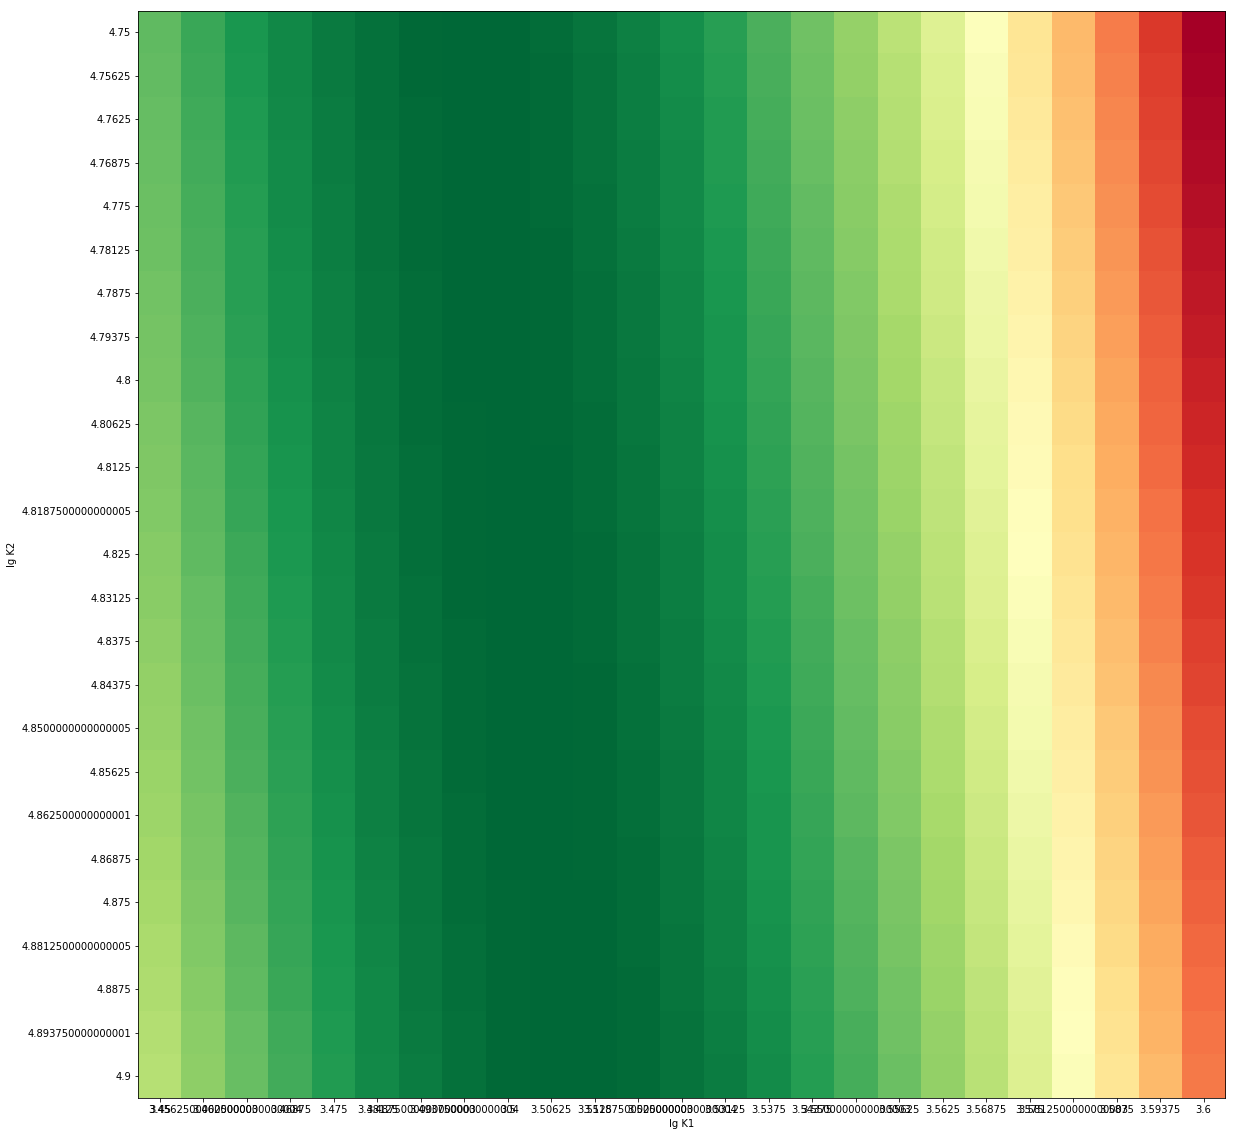

In [18]:
# heatmap : run --------------------------------------

#comment this section for reducing the waiting time

cl_htmp = cl_heatmap_fmin(max_iter, eps, st_coeff_matrix, type_con, lg_k, con_matrix, ign_indices
              , ser_num, ser_counts, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
              _calor_setup_type_coeff, _calor_setup_type, vol_init, _const_x, _const_y, _iterations)

with pd.ExcelWriter('../../output/calorimetry/' + _file_out, mode = "w") as output:
    cl_htmp.to_excel(output)

In [19]:
float("1e10")

10000000000.0